In [1]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.insert(0,'/home/cw1074/scarletmultisource/scarlet2')
sys.path.insert(0,'/home/cw1074/HSC/pulsars/scarlet')
import os
import corner
import scarlet
print(scarlet.__file__)
import astropy.io.fits as fits
from astropy.wcs import WCS
from numpyro.distributions import constraints
from scarlet.display import AsinhMapping,AsinhPercentileNorm,show_scarlet2_scene,LinearPercentileNorm
import glob
import sep
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from scarlet.source import StaticSource,MultiExtendedSource, StaticMultiExtendedSource
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
import numpyro.distributions as dist
from scarlet2 import *
import scarlet2
from scarlet2 import relative_step
from functools import partial
print(scarlet2.__file__)
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
import astrophot as ap
pixelscale=1.0#0.168

/home/cw1074/HSC/pulsars/scarlet/scarlet/__init__.py


/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/cw1074/scarletmultisource/scarlet2/scarlet2/__init__.py


In [3]:
def set_plot_style(doit=True,serif=True,use_tex=True):
    # NB -- for this to work
    # sudo apt install texlive-latex-base
    # sudo apt install msttcorefonts -qq
    # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
    # rm ~/.cache/matplotlib -rf
    from matplotlib import cycler
    new_rcparams = {
        # Set color cycle: blue, green, yellow, red, violet, gray
        #'#axes.prop_cycle' : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set color cycle: blue, orange, green, red, violet, gray
        'axes.prop_cycle' : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set default figure size
        'figure.figsize' : (4*1.5, 3*1.5),
        # Set x axis
        'xtick.direction' : 'in',
        'xtick.major.width' : 0.5,
        'xtick.minor.size' : 1.5*2,
        'xtick.minor.width' : 0.5,
        'xtick.minor.visible' : True,
        'xtick.top' : True,
        # Set y axis
        'ytick.direction' : 'in',
        'ytick.major.size' : 3*2,
        'ytick.major.width' : 0.5,
        'ytick.minor.size' : 1.5*2,
        'ytick.minor.width' : 0.5,
        'ytick.minor.visible' : True,
        'ytick.right' : True,
        # Set line widths
        'axes.linewidth' : 0.5,
        'grid.linewidth' : 0.5,
        'lines.linewidth' : 1.,
        # Remove legend' frame
        'legend.frameon' : False,
        # Always save as 'tight'
        'savefig.bbox' : 'tight',
        'savefig.pad_inches' : 0.05,
    }
    if use_tex:
        new_rcparams.update({
            # Use LaTeX for math formatting
            'text.usetex' : True,
            'text.latex.preamble' : r'\usepackage{amsmath}'
            })
    if serif:
        new_rcparams.update({
            # Use serif fonts
            'font.serif' : 'Times New Roman',
            'font.family' : 'serif',
            'mathtext.fontset' : 'dejavuserif',
            'legend.fontsize' : 'large',
            'xtick.labelsize' : 'x-large',
            'ytick.labelsize' : 'x-large',
            'axes.labelsize' : 'xx-large',
            })
    if doit:
        plt.rcParams.update(new_rcparams)
    else:
        return new_rcparams
set_plot_style()
plt.rcParams["font.family"] = "Serif"

Provide name and position of source, desired bands, and location of image data.

In [4]:
bandall=['g','i','r']
coords = np.loadtxt('/home/cw1074/ZTF/TDEpos.txt',dtype=str,skiprows=0)
srcs = coords[:,0]
print(srcs)
ras = coords[:,1]
decs = coords[:,2]
mjdstarts = coords[:,3]

#Model the 2nd TDE in the list
srcname = srcs[1]
ra = float(ras[1])
dec = float(decs[1])
mjdstart = float(mjdstarts[1])-2400000.5

coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')

imagedir = '/scratch/gpfs/cw1074/ZTFimages/'+srcname
plotdir = '/scratch/gpfs/cw1074/ZTFimages/'+srcname+'/plots'
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

['ZTF19accmaxo' 'ZTF19abhhjcc' 'ZTF19aakswrb' 'ZTF19aabbnzo'
 'ZTF19aapreis' 'ZTF19acspeuw' 'ZTF20aamqmfk' 'ZTF18actaqdw'
 'ZTF19aarioci' 'ZTF19abhejal' 'ZTF19aakiwze' 'ZTF18abxftqm'
 'ZTF18acpdvos' 'ZTF20aabqihu' 'ZTF19aatylnl' 'ZTF19abzrhgq'
 'ZTF17aaazdba']


Define a function which stacks the images and performs source detection on the stack

In [5]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in obssingle]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 5, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [6]:
obssingle=[]
observations_sc2_old=[]
channels=[]
channels_sc2 =[]
channels_zeroed=[]
times=[]
zps =[]
maglims =[]
for band in bandall:
    images = glob.glob(imagedir+'/ztf_*_z'+band+'*sciimg.resamp.cutout.fits')#[:800]#1]
    
    weights = [im.rstrip('resamp.cutout.fits')+'.resamp.weigh.cutout.fits' for im in images]
    psfs = [im.rstrip('resamp.cutout.fits')+'daopsfcent.resamp.fits' for im in images]
    
    for ind,(img,weight,psf) in enumerate(zip(images,weights,psfs)):
        #if band=='g' and (ind==2 or ind==3 or ind==23 or ind==20):
        #    continue
        if (band=='g' and ind==23) or (band=='r' and (ind==57 or ind==58)):# or ind==20):
            continue
        #Use astropy fits to read in the image file
        obs_hdu = fits.open(img)
        data_ztf = obs_hdu[0].data.byteswap().newbyteorder()
        w = WCS(obs_hdu[0].header)
        N1, N2 = data_ztf.shape
        data_ztf = data_ztf.reshape(1, N1, N2)
        data_ztf[np.isnan(data_ztf)] = 0
        #Read in the original image to get some metadata
        orig = img.rstrip('resamp.cutout.fits')+'.fits'
        try:
            orig_hdu = fits.open(orig)
        except FileNotFoundError:
            continue
        
        maglim = orig_hdu[0].header['MAGLIM']

       # if srcname=='ZTF19abhhjcc':
        if orig_hdu[0].header['OBSMJD'] > mjdstart+800 or orig_hdu[0].header['OBSMJD'] < mjdstart-200:
            continue
        if srcname=='ZTF17aaazdba':
            if orig_hdu[0].header['OBSMJD'] > 58119+375 and orig_hdu[0].header['OBSMJD'] < 58119+400:
                print('DODGY')
                continue
        #Use astropy fits to read in the weight file
        try:
            weight_hdu = fits.open(weight)
        except FileNotFoundError:
            continue
        weight_ztf = weight_hdu[0].data.byteswap().newbyteorder()
        
        Nw1, Nw2 = weight_ztf.shape
        weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
        try:
            weight_ztf[np.isnan(data_ztf)] = 0
        except IndexError:
            continue
    
        if np.sum(weight_ztf==0)>0.01*weight_ztf.shape[-2]*weight_ztf.shape[-1] or maglim<19.5:#0.001*weight_ztf.shape[-2]*weight_ztf.shape[-1]:
            #print('Poor image, skipping')
            continue
        times.append(orig_hdu[0].header['OBSMJD'])
        zps.append(orig_hdu[0].header['MAGZP'])
        orig_hdu.close()
        #Create a unique channel identifier which contains information about the band and the image index
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)

        if orig_hdu[0].header['OBSMJD']>mjdstart and orig_hdu[0].header['OBSMJD']<mjdstart+500:
            channels_zeroed.append(channel_sc2)
        #Read in the point spread function image and create the scarlet1 PSF object
        psf_ztf_data = fits.open(psf)[0].data
        #psf_ztf_data[psf_ztf_data<1e-12]=1e-12
        #psf_ztf_data = psf_ztf_data-np.min(psf_ztf_data)
        #psf_ztf_data = psf_ztf_data/np.sum(psf_ztf_data)+1e-12
        
        Np1, Np2 = psf_ztf_data.shape
        psf_ztf = scarlet.ImagePSF(psf_ztf_data)
        # Create the scarlet1 observation object and add it to our list of observations
        obs_ztf = scarlet.Observation(data_ztf,
            wcs=w,
            psf=psf_ztf,
            channels=channel,
            weights=weight_ztf)
        obssingle.append(obs_ztf)
        # Create the scarlet2 observation object and add it to our list of observations
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data)),channels=[channel_sc2],wcs=w)
        observations_sc2_old.append(obs_sc2)
        maglims.append(maglim)
print(len(channels_sc2),len(channels_zeroed))
indbest = np.argmax(maglim)
print(len(observations_sc2_old))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
592 361
592


Run source detection to create a catalog of source positions. Subtract background from images.

In [7]:
lvl = 3
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(obssingle, lvl, wave)
obssinglearr=np.asarray(obssingle)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr]
observations_sc2=[]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(obssingle,observations_sc2_old,bgsingle,globalback)):
    w = obs2.frame.wcs
    obs.weights = obs2.weights
    
    #Subtract background flux
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),channels=[channels_sc2[ind]],wcs=w)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(AsinhPercentileNorm(obs.data[:,10:-10,10:-10],percentiles=[0.01, 99]))

In [8]:
if np.asarray(ra_dec).shape==(2,):
    separ=[0]
    indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec[0]]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)
indtransientold = np.copy(indtransient)

Initialize scarlet to match up images to corresponding bands

In [9]:

epochs = np.asarray([obs.channels[0][0] for obs in obssingle])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in obssingle],return_index=True)
bands = epochs[inds0]
bandind = [np.argwhere(bands==e)[0][0] for e in epochs]
bands = epochs[inds0]
repeats = np.asarray([np.sum([epochs==b]) for b in bands],dtype=int)    


Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [10]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.9)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-2],observations_sc2[0].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2, wcs=w)
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize scarlet2 sources

In [11]:
from galaxygrad import ZTF_ScoreNet32

stepnum=3000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=ZTF_ScoreNet32
        )
ra_dec = np.asarray(ra_dec)
print(ra_dec[0])
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec[0]):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1]+1.0,pospix[0]+1.0])
        print('CENTER',center,centerpix)
        if i==indtransient:    
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0]
            for find in range(len(flux)):
                if channels_sc2[find] not in channels_zeroed:
                    flux[find]=1e-20
            flux = jnp.asarray(flux)
            print(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2
            
            scarlet2.PointSource(
                    centerpix,
                    scarlet2.TransientArraySpectrum(jnp.asarray(flux),epochs = channels_zeroed))#, stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                
            print('Making host galaxy')
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0]
            
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
                print(morph_init.shape[0],morph_init.shape[0]>30)
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    print('EXCESS',excess)
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    print('PADSIZE',padsize)
                    morph_init = np.pad(morph_init,(padsize[0], padsize[1]), 'edge') + 1e-12
                print(morph_init.shape)
                morph_init = morph_init/np.sum(morph_init)+1e-12
            except ValueError:
                print('Initializing as point source')
                #continue
                morph_init = morph_init/np.sum(morph_init)+1e-12
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(padsize[0], padsize[1]), 'edge')
                morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))

        else:
            print('Making other galaxy')
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
                #padsize=[30-morph_init.shape[0],30-morph_init.shape[1]]
                #morph_init = np.pad(morph_init,(padsize, padsize), 'constant') + 1e-12
            except ValueError:
                print('Initializing as point source')
                #continue
                morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(5, 5), 'edge')
            morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=AGN_step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=pos_step)
 
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=morph_step)
        
scene.set_spectra_to_match(observations_sc2,parameters)

[[281.30541538  44.4342352 ]
 [281.31714932  44.435646  ]
 [281.31749673  44.43865308]
 [281.31320146  44.44039795]
 [281.3201654   44.44063155]
 [281.31043391  44.44210303]
 [281.31334958  44.44388119]
 [281.30841418  44.44518955]
 [281.31488385  44.44697078]]
CENTER [281.30542   44.434235] [17.766333 63.91679 ]
Making other galaxy
Initializing as point source
(34, 34)
CENTER [281.31714   44.435646] [22.778177 34.04968 ]
Making other galaxy
(11, 11)
CENTER [281.3175    44.438652] [33.496098 33.1603  ]
[2.64109459e+01 4.52881851e+01 8.44887085e+01 4.42147331e+01
 3.98595924e+01 7.00174866e+01 7.30436325e+01 4.92986526e+01
 1.76805286e+01 3.70326309e+01 3.90116272e+01 1.03841896e+02
 9.43246002e+01 3.95947227e+01 1.02483612e+02 9.94936600e+01
 1.86699104e+01 9.99999968e-21 2.31642323e+01 5.36249199e+01
 9.99999968e-21 9.99999968e-21 2.58176384e+01 8.18590393e+01
 2.03549385e+01 1.18548691e+02 6.52254868e+01 9.99999968e-21
 1.25061157e+02 6.66197357e+01 7.92424488e+00 9.99999968e-21
 3.0

Initializing as point source
(42, 42)
CENTER [281.3132  44.4404] [39.72107  44.088238]
Making other galaxy
(11, 11)
CENTER [281.32016  44.44063] [40.544918 26.365454]
Making other galaxy
(11, 11)
CENTER [281.31042   44.442104] [45.80252  51.127865]
Making other galaxy
(11, 11)
CENTER [281.31335   44.443882] [52.136436 43.704655]
Making other galaxy
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-15.400556] at [281.31335   44.443882]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-4.2666216] at [281.31335   44.443882]
Initializing as point source
(34, 34)
CENTER [281.3084   44.44519] [56.807068 56.26115 ]
Making other galaxy
(11, 11)
CENTER [281.31488  44.44697] [63.14687  39.794655]
Making other galaxy
(8, 11)


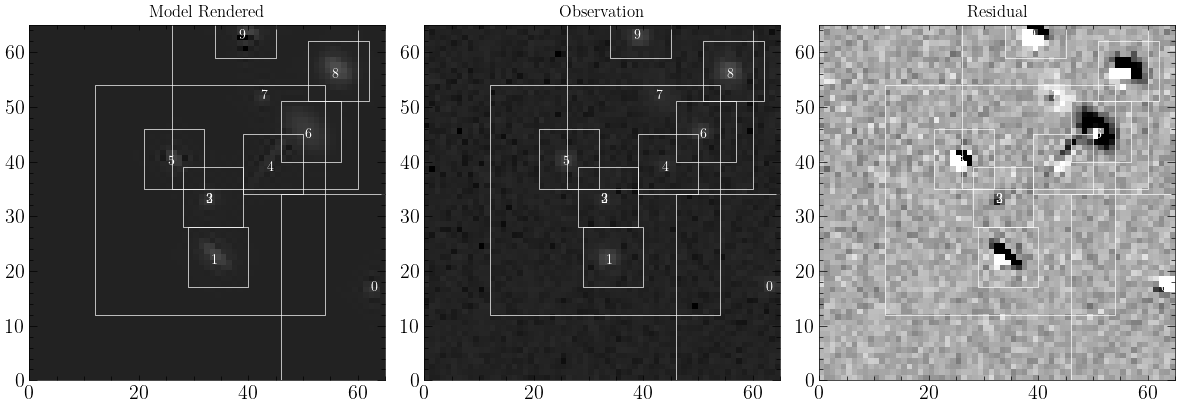

<Figure size 600x450 with 0 Axes>

In [12]:
scarlet2.plot.scene(
    scene,
    observation=observations_sc2[indbest],#np.asarray(observations_sc2),
    norm=normsingle[indbest],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()
plt.clf()

/tmp/ipykernel_409226/2885166270.py:11: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(y), cmap = cmap,interpolation=int_method)#,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))


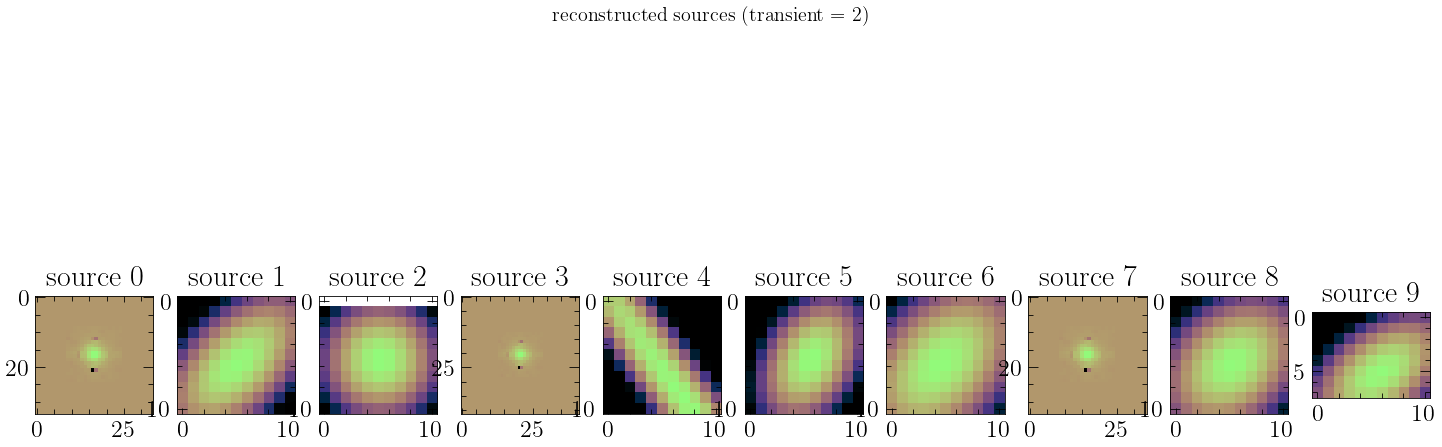

<Figure size 600x450 with 0 Axes>

In [13]:
#Show the initalization point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene.sources[i].morphology()
    else:
        y = scene.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method)#,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.show()
plt.clf()

Plot scarlet2 initializations

In [14]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
flux = scene.sources[indtransient].spectrum.data

#Fit the scene
scene_ = scene.fit(observations_sc2, parameters,max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

  0%|          | 0/3000 [00:00<?, ?it/s]2024-06-22 15:26:41.745107: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-22 15:58:39.249608: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 33m57.504198376s

********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 3000/3000 [1:57:04<00:00,  2.34s/it, loss=4726759.50, max_change=0.000032]   


(1, 65, 65)


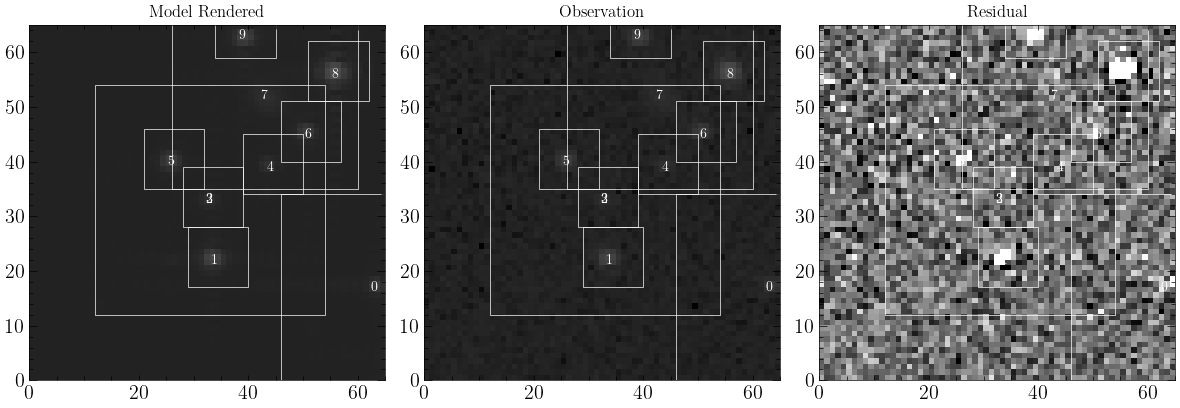

In [15]:
print(observations_sc2[0].data.shape)
scarlet2.plot.scene(
    scene_,
    observation=observations_sc2[0],#np.asarray(observations_sc2),
    norm=normsingle[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

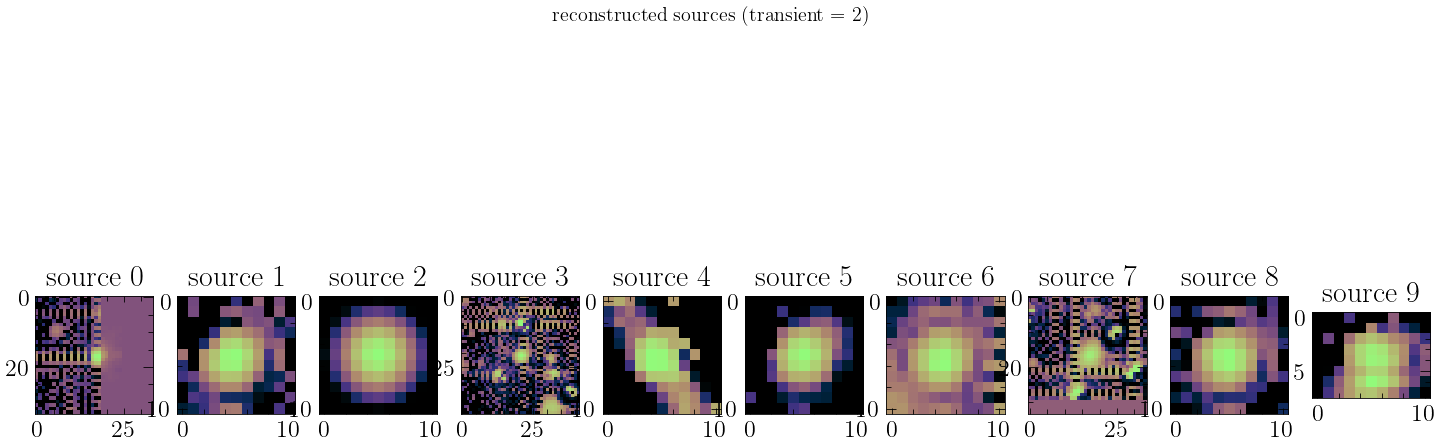

<Figure size 600x450 with 0 Axes>

In [16]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

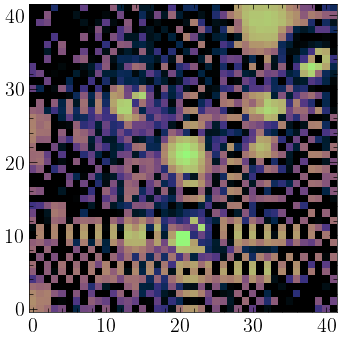

<Figure size 600x450 with 0 Axes>

In [17]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig=plt.figure(figsize=(4,4))#, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)

y = scene_.sources[indtransient+1].morphology.data
plt.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
#plt.set_title(f"source {i}", fontsize = 18)
#plt.invert_yaxis()
#plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_galaxy.pdf')
plt.show()
plt.clf()

2459319.5


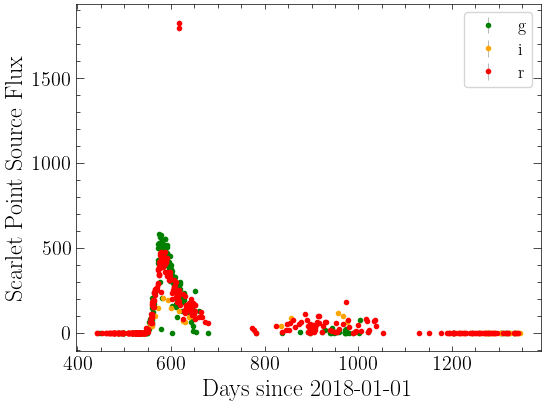

Saved /scratch/gpfs/cw1074/ZTFimages/ZTF19abhhjcc/plots/ZTF19abhhjcc_lightcurve_flux.pdf
Saved /scratch/gpfs/cw1074/ZTFimages/ZTF19abhhjcc/plots/ZTF19abhhjcc_lightcurve.pdf
Saved /scratch/gpfs/cw1074/ZTFimages/ZTF19abhhjcc/plots/ZTF19abhhjcc_lightcurve_zoom.pdf


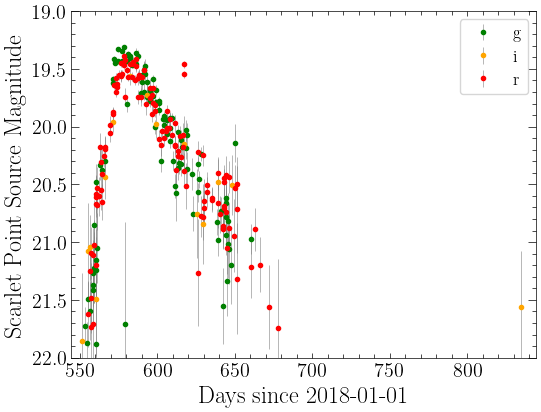

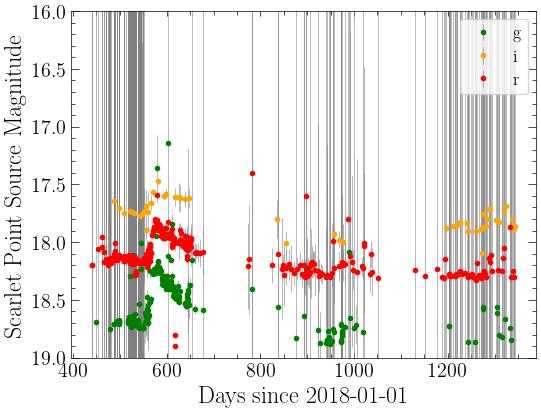

Saved /scratch/gpfs/cw1074/ZTFimages/ZTF19abhhjcc/plots/ZTF19abhhjcc_lightcurve_withgal.pdf


"\nplt.xlim((550,650))\nplt.savefig(plotdir+'/'+srcname+'_lightcurve_zoom_withgal.pdf')\nprint('Saved',plotdir+'/'+srcname+'_lightcurve_zoom_withgal.pdf')\nplt.show()\nplt.clf()\n"

<Figure size 600x450 with 0 Axes>

In [18]:
indgal=indtransient+1
zps = np.asfarray(zps)
flux = scene_.sources[indtransient].spectrum.data * np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
fluxgal = scene_.sources[indgal].spectrum.data * np.sum(scene_.sources[indgal].morphology(),axis=(-2,-1)) 
times=np.asfarray(times)
timesz = ['2018-01-01T00:00:00']
t = Time(timesz, format='isot', scale='utc')
now = t[0]
print(now.jd+1200)
for bind,(b,c,background) in enumerate(zip(['g','i','r'],['green','orange','red'],bgsinglearr)):
        plt.errorbar(times[epochs==b]-now.mjd,flux[epochs==b],yerr = bgsinglearr[epochs==b][:,0],label=b,color=c,marker='.',linestyle=' ',ecolor='grey',elinewidth=0.4,capthick=0.4)# +fluxgal[bind]
        #plt.scatter(times[epochs==b]-57700,22.5-2.5*np.log10(flux[epochs==b]+fluxgal[bind]),label=b,color=c,marker='.')
plt.xlabel('Days since 2018-01-01')
#plt.ylim((22,17.5))#20,15))
#plt.xlim((500,800))
plt.ylabel('Scarlet Point Source Flux')
plt.legend(frameon=True)
#plt.title(srcname)
plt.show()
plt.savefig(plotdir+'/'+srcname+'_lightcurve_flux.pdf')
#print(zps)
print('Saved',plotdir+'/'+srcname+'_lightcurve_flux.pdf')
for bind,(b,c,background) in enumerate(zip(['g','i','r'],['green','orange','red'],bgsinglearr)):
        mags = zps[epochs==b]-2.5*np.log10(flux[epochs==b])
        plt.errorbar(times[epochs==b][mags<22]-now.mjd,mags[mags<22],yerr = 1.0857*bgsinglearr[epochs==b][mags<22][:,0]*3/flux[epochs==b][mags<22],label=b,color=c,marker='.',linestyle=' ',ecolor='grey',elinewidth=0.4,capthick=0.4)# +fluxgal[bind]
        #plt.scatter(times[epochs==b]-57700,22.5-2.5*np.log10(flux[epochs==b]+fluxgal[bind]),label=b,color=c,marker='.')
plt.xlabel('Days since 2018-01-01')
plt.gca().invert_yaxis()
plt.ylim((22,19))#20,15))
plt.xlim((500,850))
plt.ylabel('Scarlet Point Source Magnitude')
plt.legend(frameon=True)
#plt.title(srcname)

plt.savefig(plotdir+'/'+srcname+'_lightcurve.pdf')
print('Saved',plotdir+'/'+srcname+'_lightcurve.pdf')
plt.xlim((mjdstart-now.mjd,mjdstart-now.mjd+300))
plt.savefig(plotdir+'/'+srcname+'_lightcurve_zoom.pdf')
print('Saved',plotdir+'/'+srcname+'_lightcurve_zoom.pdf')
plt.show()
plt.clf()

for bind,(b,c,background) in enumerate(zip(['g','i','r'],['green','orange','red'],bgsinglearr)):
        mags = zps[epochs==b]-2.5*np.log10(flux[epochs==b]+fluxgal[bind])
        plt.errorbar(times[epochs==b][mags<22]-now.mjd,mags[mags<22],yerr = 1.0857*bgsinglearr[epochs==b][mags<22][:,0]/flux[epochs==b][mags<22],label=b,color=c,marker='.',linestyle=' ',ecolor='grey',elinewidth=0.4,capthick=0.4)# +fluxgal[bind]
        #plt.scatter(times[epochs==b]-57700,22.5-2.5*np.log10(flux[epochs==b]+fluxgal[bind]),label=b,color=c,marker='.')
plt.xlabel('Days since 2018-01-01')
plt.gca().invert_yaxis()
plt.ylim((19,16))#20,15))
#plt.xlim((500,800))
plt.ylabel('Scarlet Point Source Magnitude')
plt.legend(frameon=True)
#plt.title(srcname)
plt.show()
plt.savefig(plotdir+'/'+srcname+'_lightcurve_withgal.pdf')
print('Saved',plotdir+'/'+srcname+'_lightcurve_withgal.pdf')
'''
plt.xlim((550,650))
plt.savefig(plotdir+'/'+srcname+'_lightcurve_zoom_withgal.pdf')
print('Saved',plotdir+'/'+srcname+'_lightcurve_zoom_withgal.pdf')
plt.show()
plt.clf()
'''

import gzip
with gzip.open('/home/cw1074/ZTF/ZTF-AGN/ZTFimages/lightcurves/'+srcname+'-lc-f.dat.gz') as f:
    content = np.loadtxt(f,skiprows=1,dtype=str)
    #content = f.read()
    jd = np.asfarray(content[:,0])-2400000.5 - 57700
    bands = content[:,7]
    mags = np.asfarray(content[:,4])
    magerr = np.asfarray(content[:,5])
for b,c in zip(['g','r','i'],['green','red','orange']):
    plt.errorbar(jd[bands==b],mags[bands==b],yerr=magerr[bands==b],label=b,color=c,marker='.',linestyle=' ')
plt.xlabel('JD-57700')
plt.gca().invert_yaxis()
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [19]:
getphotometry=False
if getphotometry==True:
    scene_.set_info(scene_.parameters.keys(), fixed=True) 
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 0.01*scene_.sources[indtransient].spectrum.data))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
    mcmc = scene_.sample(observations_sc2,num_warmup=50, num_samples=100) 
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data'] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
    fluxes = [] 
    fluxerrors = [] 
    for i in range(q1.shape[1]): 
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
        fluxes.append(q1[2][i]*fac) 
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

    mcmc.print_summary() 
    #Uncomment this to show the corner plot
    #corner.corner(mcmc).show() 
    #plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
    #plt.show()
    #plt.clf()
    zps = np.asfarray(zps)
    fluxes = np.asfarray(fluxes)
    fluxerrors = np.asfarray(fluxerrors)
    times=np.asfarray(times)
    print(times,epochs,flux,fluxerrors)


    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))

    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.errorbar(times[epochs==b]-57700,fluxes[epochs==b],yerr = fluxerrors[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
    plt.show()
    plt.clf()
    outlchead=['MJD','FLUX','FLUXERR','BAND']
    outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
    outlc = np.vstack((outlchead,outlc))
    np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
    sed=[]
    sederr=[]
    for b,c in zip(bandall,['green','orange','red','purple','blue']):
        sed.append(np.mean(fluxes[epochs==b]))
        sederr.append(np.std(fluxes[epochs==b]))
        plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
    plt.show()

In [ ]:
from numpyro.infer.initialization import init_to_sample

parameters = scene_.make_parameters()
p = scene_.sources[indtransient].morphology.center
prior = dist.Normal(p, scale=1)
parameters += Parameter(p, name=f"morphology.data:"+str(indtransient+1), prior=prior)
parameters += Parameter(p, name=f"morphology.center:"+str(indtransient), prior=prior)
#parameters += Parameter(p, name=f"spectrum:"+str(indtransient), prior=prior)
#print(parameters)

print(scene_.sources[indtransient].morphology.center)


mcmc = scene_.sample(observations_sc2,parameters,num_warmup=400, num_samples=1000, dense_mass=True, init_strategy=init_to_sample) 

q = mcmc.get_samples()['morphology.center:'+str(indtransient)] 

q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
print('q1',q1)
centerAGN = np.asfarray([q1[2,0],q1[2,1]])
errorAGN = np.asarray([np.abs(q1[3,0]-q1[1,0]),np.abs(q1[3,1]-q1[1,1])])
print(centerAGN,errorAGN)
corner.corner(mcmc).show() 
plt.savefig(plotdir+'/'+srcname+'_transientcenter_corner.png')
plt.show()
plt.clf()


[32.993168 32.914772]


  0%|          | 0/1400 [00:00<?, ?it/s]2024-06-22 18:12:24.772781: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 50m6.254055012s

********************************
[Compiling module jit__body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
warmup:   2%|▏         | 26/1400 [1:29:55<73:04:09, 191.45s/it, 1023 steps of size 8.41e-06. acc. prob=0.61]

In [ ]:
import copy
observations_sc2_arr =np.asarray(observations_sc2)
normsinglearr =np.asarray(normsingle)
obs_subtracted=[]
for i,(chan,obs,norm) in enumerate(zip(channels,observations_sc2_arr[:30],normsinglearr[:30])):
    model_ = obs.render(scene_.sources[indtransient]())
    boxslice = scene_.sources[indtransient].bbox.slices
    newdata = copy.deepcopy(np.asarray(obs.data)) 
    newdata[boxslice] = newdata[boxslice] - model_
    obs2 = scarlet2.Observation(jnp.asarray(newdata), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.frame.psf())),channels=obs.frame.channels)
    obs2.match(model_frame_sc2)
    obs_subtracted.append(obs2)

In [ ]:
obs_subtracted=[]
for i,(chan,obs) in enumerate(zip(channels_sc2,observations_sc2_arr)):
    newdata = copy.deepcopy(np.asarray(obs.data)) 
    for isource,src in enumerate(scene_.sources):
        #print(isource)
        if isource==indtransient+1:
            continue
        model_ = obs.render(scene_.sources[isource]())
        
        #print(newdata.shape,model_.shape,scene_.sources[isource].morphology.bbox)#.slices)
        #print(scene_.sources[isource].bbox)
        #scene_.sources[isource].morphology.bbox.origin[0] or 
        boxslice = scene_.sources[isource].bbox.slices
        #print(boxslice)
        overlap1,overlap2 = bbox.overlap_slices(scene_.sources[indtransient].bbox, scene_.sources[isource].bbox)
        try:
            newdata[boxslice] = newdata[boxslice] - model_
            #newdata[overlap1] = newdata[overlap1] - model_[overlap2]
        except TypeError:
            print('Slicing operation failure',i,isource)
    plt.imshow(newdata[0])
    obs2 = scarlet2.Observation(jnp.asarray(newdata), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.frame.psf())),channels=obs.frame.channels)

    obs2.match(model_frame_sc2)
    obs_subtracted.append(obs2)


In [ ]:
obs_subtractedarr = np.asarray(obs_subtracted)
'''
for i,(chan,obs,norm) in enumerate(zip(channels[:10],obs_subtractedarr[:10],normsinglearr[:10])):
    model_ = obs.render(scene2())
    scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

    plt.show()
'''

In [ ]:

multichannel = []
multiimage=[]
multivar=[]
multipsf=[]
for i in range(len(['g','i','r'])):
    bind = np.argwhere(np.asarray(bandind)==i)[:,0]
    if len(bind)==0:
        continue
    weights = np.asarray([obs.weights for obs in obs_subtractedarr[bind]])
    weights[weights==0] = 1e-10
    multivar.append(np.median(np.asarray([obs.weights for obs in obs_subtractedarr[bind]]),axis=0)*np.sqrt(len(obs_subtractedarr[bind])))
    multiimage.append(np.average(np.asarray([obs.data for obs in obs_subtractedarr[bind]]),axis=0,weights=weights)[0])
    
    multipsf.append(np.mean(np.asarray([obs.frame.psf() for obs in obs_subtractedarr[bind]]),axis=0)[0])
    channel_sc2 = bandall[i]#(bandall[i], '0')
    
    multichannel.append(channel_sc2)
print(multichannel)
obs_sc2 = scarlet2.Observation(jnp.asarray(multiimage), jnp.asarray(multivar),psf=scarlet2.ArrayPSF(jnp.asarray(multipsf)),channels=multichannel)#,wcs=w)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((np.asarray(multiimage).shape[0],np.asarray(multiimage).shape[-1],np.asarray(multiimage).shape[-2])), psf=frame_psf_sc2, channels=multichannel)

In [ ]:
print(obs_sc2.data.shape,norm)
norm = LinearPercentileNorm(obs.data[-1,10:-10,10:-10],percentiles=[0.01, 98])
plt.figure(figsize=(4,4))
scarlet2.plot.observation(obs_sc2,norm=norm,show_psf=True,add_labels=False)#sky_coords=ra_dec[0])
plt.savefig(plotdir+'/'+srcname+'_transientsubtractedimage.pdf')
print('Saved',plotdir+'/'+srcname+'_transientsubtractedimage.pdf')

In [ ]:
stepnum=500
from galaxygrad import ZTF_ScoreNet32
prior_model = ZTF_ScoreNet32
with scarlet2.Scene(model_frame_sc2) as scene3:
    for i,pos in enumerate(ra_dec[0]):  
    
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        
        if i==indtransient:
        #    continue
        #elif i==indtransient:
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center) + 1e-6
            except ValueError:
                #continue
                morph_init = observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf())
                morph_init = morph_init/np.sum(morph_init)+1e-12
           
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1
           
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])
            
    
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
            
parameters = scene3.make_parameters()
for i in range(len(scene3.sources)):
        parameters += Parameter(scene3.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene3.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=morph_step)
print(parameters)        
scene.set_spectra_to_match(observations_sc2,parameters)

In [ ]:
scarlet2.plot.scene(
    scene3,
    observation=obs_sc2,#np.asarray(observations_sc2),
    norm=normsingle[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

In [ ]:
scene3_ = scene3.fit(obs_sc2, parameters,max_iter=stepnum, e_rel=1e-6, schedule=schedule)
model_ = obs_sc2.render(scene3_())
scarlet2.plot.scene(
    scene3_,
    observation=obs_sc2,#np.asarray(observations_sc2),
    norm=normsingle[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

In [ ]:
scarlet2.plot.scene(scene3_,
                           norm=norm,
                           observation=obs_sc2,
                           show_rendered=False,
                           show_observed=True,
                           show_residual=True,
                           add_labels=False,
                           #figsize=(12,4)
                          )
plt.savefig(plotdir+'/'+srcname+'_hostmodel_withresidual.pdf')
print('Saved',plotdir+'/'+srcname+'_hostmodel_withresidual.pdf')
scarlet2.plot.scene(scene3_,
                           norm=norm,
                           observation=obs_sc2,
                           show_rendered=False,
                           show_observed=True,
                           show_residual=False,
                           add_labels=False,
                           #figsize=(8,4)
                          )
plt.savefig(plotdir+'/'+srcname+'_hostmodel.pdf')
print('Saved',plotdir+'/'+srcname+'_hostmodel.pdf')

In [ ]:
stepnum=500
from galaxygrad import ZTF_ScoreNet32
prior_model = ZTF_ScoreNet32
with scarlet2.Scene(model_frame_sc2) as scene3:
    for i,pos in enumerate(ra_dec[0]):  
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord),dtype=int)
        
        #center = jnp.asarray([pos[0],pos[1]])#ospix[1],pospix[0]])
        centerpix = jnp.asarray(np.asfarray([pospix[1],pospix[0]]))+1
        center = centerpix
        print(pos,'CENTER',center,centerpix)
        if i==indtransient:
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(obs_sc2, center))+1e-6)
            n_steps, peak_value = stepnum, 1#jnp.max(flux)
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)#lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, 0.1*jnp.max(flux[~np.isinf(flux)])
            print('Making source')
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            sersic = scarlet2.SersicMorphology(
                                        center = #scarlet2.module.Parameter(
                                                jnp.asarray(np.asfarray(center)),
                                                #constraint=constraints.positive,
                                                #stepsize=1e-2),
                                        ellipticity = jnp.asarray([0.1,0.1]),#scarlet2.module.Parameter(jnp.asarray([0.1,0.1]),
                                            #constraint=constraints.interval(0,1),
                                            #stepsize=1e-3),
                                        size= jnp.asarray(3.0),#scarlet2.module.Parameter(jnp.asarray(3.0),  
                                                #constraint=constraints.interval(1.0,15),
                                                #stepsize=1e-2),
                                        n=jnp.asarray(1.5),#scarlet2.module.Parameter(jnp.asarray(1.5),
                                            #constraint=constraints.interval(.5,10),
                                            #stepsize=1e-3),

                        )
            scarlet2.Source(
                center,
                scarlet2.ArraySpectrum(jnp.asarray(flux)) ,sersic)
            
parameters = scene3.make_parameters()

for i in range(len(scene3.sources)):   
    parameters += Parameter(scene3.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
    parameters += Parameter(scene3.sources[i].morphology.center, name=f"morph.{i}", constraint=constraints.positive, stepsize=pos_step)
    parameters += Parameter(scene3.sources[i].morphology.ellipticity, name=f"morph.{i}", constraint=constraints.interval(0,1), stepsize=1e-3)
    parameters += Parameter(scene3.sources[i].morphology.size, name=f"morph.{i}", constraint=constraints.interval(1.0,15), stepsize=5e-2)
    parameters += Parameter(scene3.sources[i].morphology.n, name=f"morph.{i}", constraint=constraints.interval(.5,10), stepsize=1e-3)
print(parameters) 
  

In [ ]:
scarlet2.plot.scene(
    scene3,
    observation=obs_sc2,#np.asarray(observations_sc2),
    norm=normsingle[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

In [ ]:
scene3_ = scene3.fit(obs_sc2,parameters, max_iter=stepnum, e_rel=1e-6, schedule=schedule)
print(scene3.sources[0].morphology.center)
print(scene3_.sources[0].morphology.center)
model_ = obs_sc2.render(scene3_())
scarlet2.plot.scene(
    scene3_,
    observation=obs_sc2,#np.asarray(observations_sc2),
    norm=normsingle[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    #figsize=None,
    linear=True,
)
plt.show()

In [ ]:

parameters = scene3_.make_parameters()
p = scene3_.sources[0].morphology.center
print('HERE',p)
prior = dist.Normal(p, scale=1)
#p2 = scene3_.sources[0].spectrum
#prior2 = dist.Normal(p2, scale=1)
parameters += Parameter(p, name=f"morphology.center:"+str(0), prior=prior)
p = scene3_.sources[0].morphology.ellipticity
parameters += Parameter(p, name=f"morphology.ellipticity:"+str(0), prior=dist.Normal(p, scale=0.5))
p = scene3_.sources[0].morphology.size
parameters += Parameter(p, name=f"morphology.size:"+str(0), prior=dist.Normal(p, scale=1.0))
p = scene3_.sources[0].morphology.n
parameters += Parameter(p, name=f"morphology.n:"+str(0), prior=dist.Normal(p, scale=0.5))
p = scene3_.sources[0].spectrum.data
parameters += Parameter(p, name=f"spectrum:"+str(0), prior=dist.Normal(p, scale=1.0))


mcmc = scene3_.sample(obs_sc2,parameters,num_warmup=600, num_samples=1300,dense_mass=True, init_strategy=init_to_sample) 
q = mcmc.get_samples()['morphology.center:'+str(0)] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
print(q1)
centergal = np.asfarray([q1[2,0],q1[2,1]])
errorgal = np.asarray([np.abs(q1[4,0]-q1[0,0]),np.abs(q1[4,1]-q1[0,1])])
print(centerAGN,errorAGN,centergal,errorgal)
corner.corner(mcmc).show() 
plt.savefig(plotdir+'/'+srcname+'_galcenter_corner.png')
plt.show()
plt.clf()


offset = np.linalg.norm(centergal - centerAGN)
dx = centerAGN[0]-centergal[0]
dy = centerAGN[1]-centergal[1]

sigx = errorAGN[0]/centerAGN[0]+errorgal[0]/centergal[0]
sigy = errorAGN[1]/centerAGN[1]+errorgal[1]/centergal[1]

error = np.sqrt(1/offset**2*(dx**2*(errorAGN[0]**2+errorgal[0]**2)+dy**2*(errorAGN[1]**2+errorgal[1]**2)))
errorpix = errorAGN+errorgal

print('Offset',offset,error,errorpix)
np.savetxt(plotdir+'/offset.txt',np.asarray([offset,error,centerAGN[0],centerAGN[1],centergal[0],centergal[1]],dtype=str),fmt='%s')